__Purpose:__ Run FedAvg but with different hyperparameters.  Mainly:
1. C: Fraction of clients used in training
1. local_round_thresh: probably should lower since local cost seems to reach zero super early... and also only advances one update?
1. smoothbatch
1. PCA_comps
1. num_steps?

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [4]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# Federated Learning
> 1000 Iterations <br>
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.
## 1SS, Varying local_round_thresh


## Default: 50

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 392, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 815, 100)

(Current Local Round, Current Local Update)
(172, 13)
(119, 12)
(136, 12)
(147, 12)
(133, 12)
(143, 12)
(152, 13)
(140, 12)
(136, 12)
(153, 13)
(137, 12)
(125, 12)
(155, 13)
(152, 13)


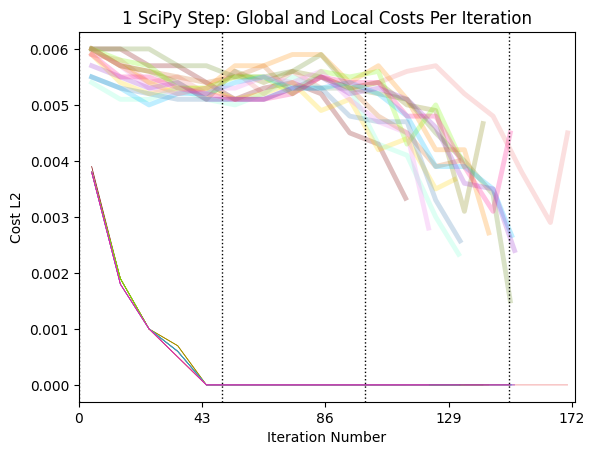

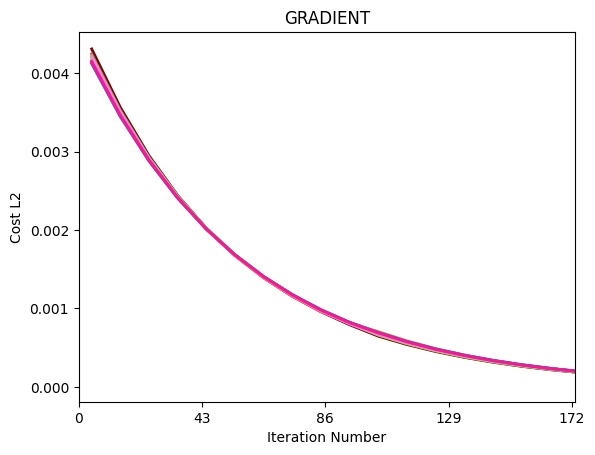

In [5]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

## 25

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 199, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 320, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 505, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 690, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 842, 125)

(Current Local Round, Current Local Update)
(153, 16)
(148, 15)
(136, 15)
(148, 15)
(131, 15)
(138, 15)
(136, 15)
(141, 15)
(163, 16)
(138, 15)
(137, 15)
(163, 16)
(143, 15)
(125, 15)


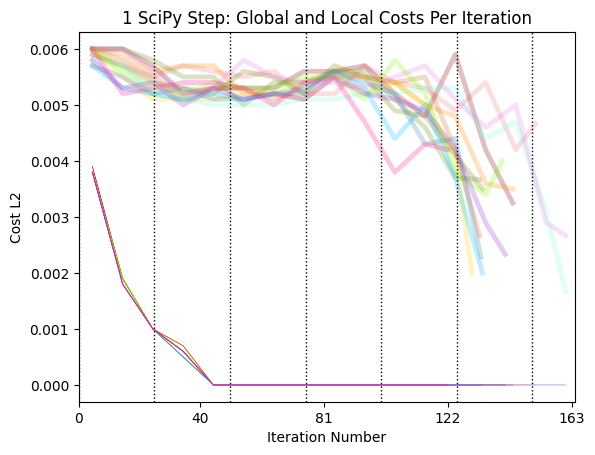

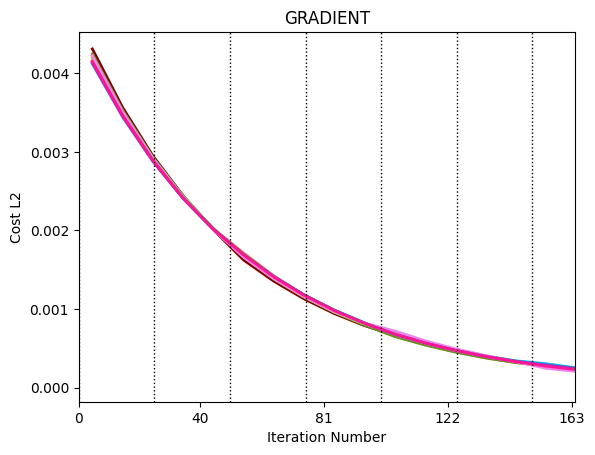

In [6]:
reduced_limit = 25

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## 10

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 61, 10)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 151, 20)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 220, 30)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 301, 40)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 363, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 459, 60)

(Current Local Round, Current Local Update)
(147, 16)
(135, 16)
(168, 16)
(147, 16)
(139, 16)
(142, 16)
(121, 16)
(111, 16)
(132, 16)
(147, 16)
(148, 16)
(146, 16)
(167, 16)
(150, 16)


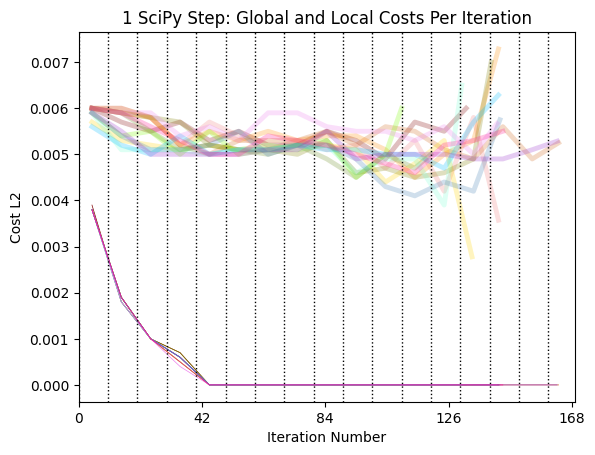

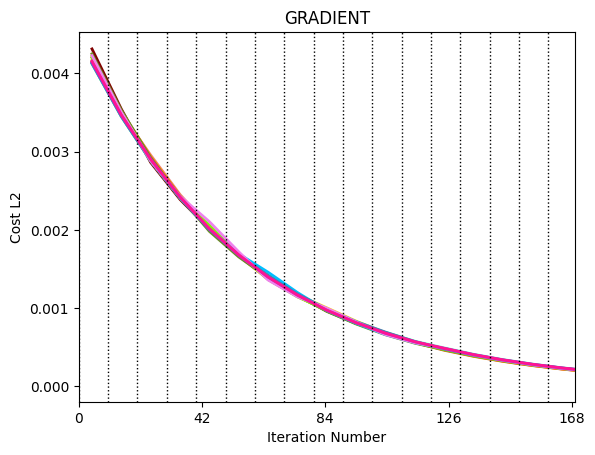

In [7]:
reduced_limit = 10

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## 1

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 2, 1)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 5, 2)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 15, 3)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 16, 4)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 19, 5)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 26, 6)

(Current Local Round, Current Local Update)
(140, 16)
(140, 16)
(155, 16)
(147, 16)
(127, 16)
(150, 16)
(136, 16)
(159, 16)
(167, 16)
(144, 16)
(146, 16)
(151, 16)
(112, 16)
(126, 16)


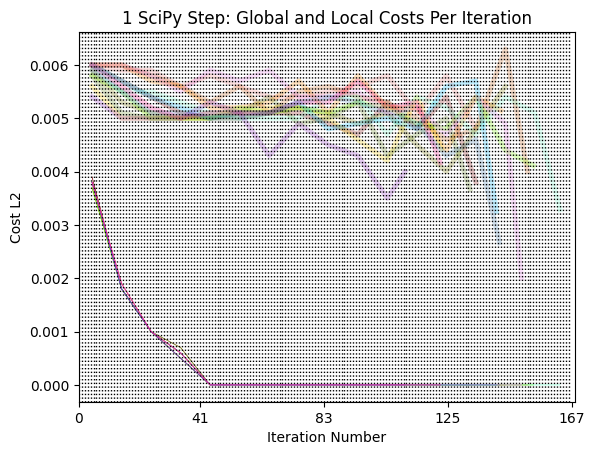

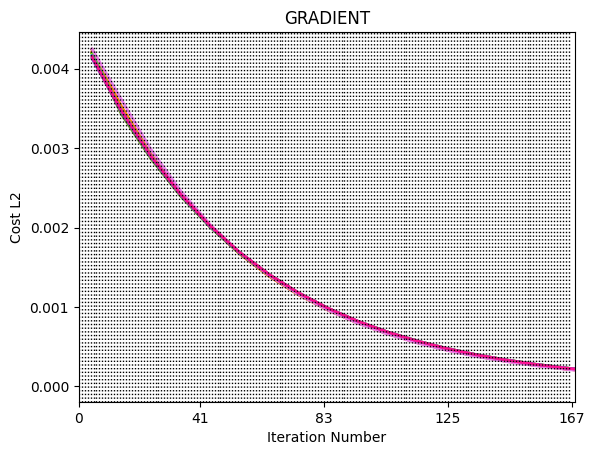

In [8]:
reduced_limit = 1

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

## 100

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 713, 100)

(Current Local Round, Current Local Update)
(152, 11)
(139, 11)
(123, 11)
(136, 11)
(145, 11)
(158, 11)
(147, 11)
(128, 11)
(144, 11)
(141, 11)
(154, 11)
(157, 11)
(140, 11)
(136, 11)


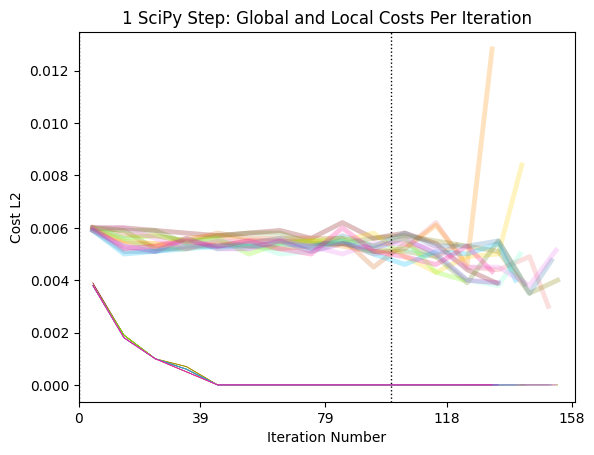

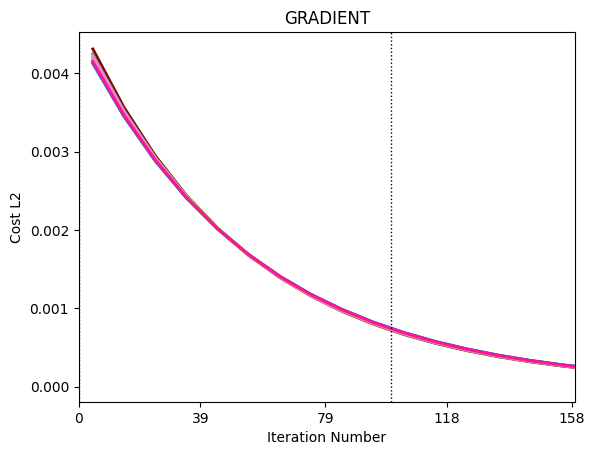

In [9]:
reduced_limit = 100

user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 1000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, custom_title='GRADIENT')

In [ ]:
assert(1==0)

<hr>

# Increasing the number of scipy steps per iter
## 50 Scipy Steps

(137, 12)
(145, 12)
(141, 12)
(146, 12)
(139, 12)
(139, 12)
(151, 13)
(135, 12)
(151, 13)
(131, 12)
(143, 12)
(137, 12)
(159, 13)
(146, 12)


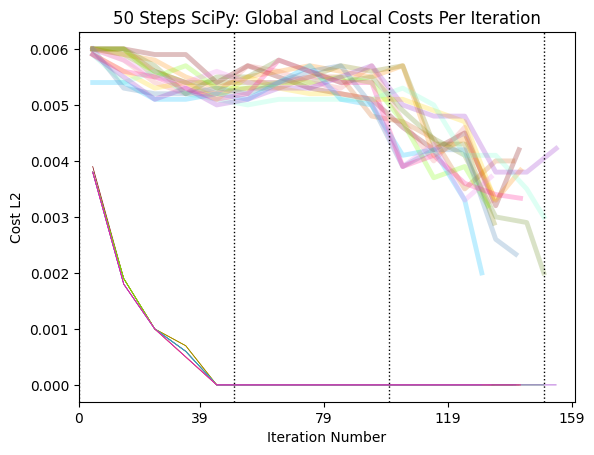

In [10]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=50, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
for my_client in global_model_10scipy.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_10scipy, 'local', custom_title='50 Steps SciPy: Global and Local Costs Per Iteration')

## 50 Scipy Steps

(144, 12)
(139, 12)
(143, 12)
(140, 12)
(123, 12)
(156, 13)
(154, 13)
(139, 12)
(137, 12)
(150, 13)
(145, 12)
(131, 12)
(150, 13)
(149, 12)


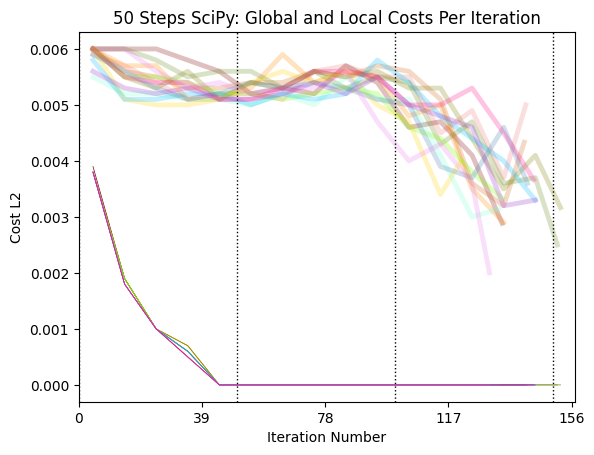

In [11]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=100, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
for my_client in global_model_10scipy.all_clients:
    print((my_client.current_round, my_client.current_update))
    
condensed_external_plotting(user_c0_10scipy, 'local', custom_title='50 Steps SciPy: Global and Local Costs Per Iteration')